# Purpose of this notebook

This notebook produced the numpy arrays required for ml_test.ipynb from 20 second labeled pcaps. 

In [98]:
import os
import numpy as np
from tqdm import tqdm
from scapy.all import *
from datetime import datetime as dt
from matplotlib import pyplot as plt
from scapy.layers.all import Raw
from math import floor

from functions import vis_df_category

ImportError: cannot import name 'vis_df_category' from 'functions' (/Users/michaelkearney/Documents/Uni/UNB_Datasets/functions.py)

In [36]:
TIMEFRAME = 20          # Number of seconds per captured frame
NAME = "AWS_61k_TOR"
_NAME = "AWS_61k_VPN"
MIN_PACKETS = 50
CLIENT_SUBNET = "172"

Run below to scrape from S3.

In [3]:
!mkdir ~/Documents/Uni/UNB_Datasets/pcaps/{_NAME};
!aws s3 sync s3://pcaps-for-wfa ~/Documents/Uni/UNB_Datasets/pcaps/{_NAME};

mkdir: /Users/michaelkearney/Documents/Uni/UNB_Datasets/pcaps/AWS_61k_VPN: File exists


In [37]:
path = f"/Users/michaelkearney/Documents/Uni/UNB_Datasets/pcaps/{_NAME}"



In [38]:
dir_list = os.listdir(path)
clips = [os.path.join(path, clip) for clip in dir_list if clip[-4:] == "pcap" and clip[-8:-5] == "tor"]
clips[:10]

['/Users/michaelkearney/Documents/Uni/UNB_Datasets/pcaps/AWS_61k_VPN/checkshield.net-WFP_win_client_7-104-15-2023_04_11__21_12_30-tor.pcap',
 '/Users/michaelkearney/Documents/Uni/UNB_Datasets/pcaps/AWS_61k_VPN/google.com-WFP_win_client_3-0-18-2023_04_14__03_05_37-tor.pcap',
 '/Users/michaelkearney/Documents/Uni/UNB_Datasets/pcaps/AWS_61k_VPN/etsy.com-WFP_win_client_7-55-19-2023_04_14__02_23_59-tor.pcap',
 '/Users/michaelkearney/Documents/Uni/UNB_Datasets/pcaps/AWS_61k_VPN/facebook.com-WFP_win_client_7-2-16-2023_04_13__21_23_06-tor.pcap',
 '/Users/michaelkearney/Documents/Uni/UNB_Datasets/pcaps/AWS_61k_VPN/18comic.vip-WFP_win_client_3-93-16-2023_04_13__19_58_50-tor.pcap',
 '/Users/michaelkearney/Documents/Uni/UNB_Datasets/pcaps/AWS_61k_VPN/thoughtco.com-WFP_win_client_7-107-19-2023_04_14__02_23_10-tor.pcap',
 '/Users/michaelkearney/Documents/Uni/UNB_Datasets/pcaps/AWS_61k_VPN/hbomax.com-WFP_win_client_1-67-17-2023_04_12__12_18_47-tor.pcap',
 '/Users/michaelkearney/Documents/Uni/UNB_Data

In [39]:
len(clips)

27910

In [40]:
clip = rdpcap(clips[1])

This one is a try at using sparse arrays. It should be faster and use less RAM. If it does not work, try the next one.

In [49]:
def is_inbound(packet):
    if packet[IP].src[:3] == CLIENT_SUBNET:
        return False
    else:
        return True

def extract_features_from_clips(clip):

    matrix_small = np.zeros([TIMEFRAME * 10, 150, 2])
    df_tcp_encoding = np.zeros(5000, dtype=int)
    df_tor_encoding = np.zeros(5000, dtype=int)
    cumul_tcp_encoding = np.zeros(100)
    cumul_tor_encoding = np.zeros(100)

    start_time = clip[0].time

    ip_count = 0
    tor_count = 0

    for i, pkt in enumerate(clip):
        if IP in pkt:
        
            tor_cell = False
            tor_cells = 0

            time_round = round(pkt.time - start_time, 2)
            size = pkt[IP].len
            inbound = is_inbound(pkt)

            if Raw in pkt and bytes(pkt[Raw])[:3] == b'\x17\x03\x03':
                byte_data = bytes(pkt[Raw])[3:5]
                int_data = int.from_bytes(byte_data, byteorder='big')
                tor_cells = floor(int_data / 512)
                tor_cell = True

            if time_round <= 20: #Matrix only takes first 20 seconds. Although pcaps were set to 20 sec, delay in closing tshark can cause some be be longer.

                # Matrix small

                length = (lambda x: x if x <= 1500 else 1500)(size) # Packets over 1500 are rounded down to 1500
                dir = (lambda: 0 if inbound else 1)()
                time_round = round(pkt.time - start_time, 2) 
                matrix_small[int(round(time_round, 1) * 10)-1][int(length / 10)-1][dir] += 1

                # # Matrix large

                # matrix_large[int(time_round * 100)-1][int(length)-1][dir] += 1

            # DF

            # DF tcp

            if ip_count < 5000:

                if inbound:
                    df_tcp_encoding[ip_count] = 1
                else:
                    df_tcp_encoding[ip_count] = -1

            # DF tor

            if (tor_count + tor_cells) < 5000  and tor_cell:
                for cell in range(tor_cells):
                    if inbound:
                        df_tor_encoding[tor_count + cell] = 1
                    else:
                        df_tor_encoding[tor_count + cell] = -1

            # CUMUL

            # CUMUL tcp

            if ip_count < 100:

                if inbound:
                    cumul_tcp_encoding[ip_count] += size
                else:
                    cumul_tcp_encoding[ip_count] -= size

            # CUMUL tor

            if tor_count < 100 and tor_cell:

                if inbound:
                    cumul_tor_encoding[tor_count] += tor_cells
                else:
                    cumul_tor_encoding[tor_count] -= tor_cells
            
            ip_count += 1
            if tor_cell:
                tor_count += tor_cells
                
                
    return np.array(matrix_small), np.array(df_tcp_encoding), np.array(df_tor_encoding), np.cumsum(np.array(cumul_tcp_encoding)), np.cumsum(np.array(cumul_tor_encoding))
    

In [50]:
labels = []
matrix = []
encoded_cumul_tcp = []
encoded_cumul_tor = []
encoded_df_tcp = []
encoded_df_tor = []


for idx, file in enumerate(tqdm(clips)):
        clip = rdpcap(file)

        if len(clip) >= MIN_PACKETS:
            
            pet = file[-8:-5]

            label = clips[idx][len(path)+1:].split("-")[0]
            label = label.split("-")[0]



            matrix_encoding, encoding_df_tcp, encoding_df_tor, encoding_cumul_tcp, encoding_cumul_tor = extract_features_from_clips(clip)


            matrix.append(matrix_encoding)
            # vpn_matrix_large.append(matrix_large)
            encoded_df_tcp.append(encoding_df_tcp)
            encoded_df_tor.append(encoding_df_tor)
            encoded_cumul_tcp.append(encoding_cumul_tcp)
            encoded_cumul_tor.append(encoding_cumul_tor)
            labels.append(label)




100%|██████████| 27910/27910 [10:50:10<00:00,  1.40s/it]   


In [51]:
features_matrix = np.array(matrix)
del(matrix)
features_cumul_tcp = np.array(encoded_cumul_tcp)
del(encoded_cumul_tcp)
features_cumul_tor = np.array(encoded_cumul_tor)
del(encoded_cumul_tor)
features_df_tcp = np.array(encoded_df_tcp)
del(encoded_df_tcp)
features_df_tor = np.array(encoded_df_tor)
del(encoded_df_tor)
labels = np.array(labels)



In [52]:
import sys
from pympler import asizeof

def format_size(size_in_bytes):
    if size_in_bytes < 1024:
        return f"{size_in_bytes} bytes"
    elif size_in_bytes < 1024 ** 2:
        return f"{size_in_bytes / 1024:.2f} KB"
    elif size_in_bytes < 1024 ** 3:
        return f"{size_in_bytes / (1024 ** 2):.2f} MB"
    else:
        return f"{size_in_bytes / (1024 ** 3):.2f} GB"


print(f"""vpn features shape:
        Matrix:{features_matrix.shape} - Shallow size: {format_size(sys.getsizeof(features_matrix))} - Full size: {format_size(asizeof.asizeof(features_matrix))}
        CUMUL TCP:{features_cumul_tcp.shape} - Shallow size: {format_size(sys.getsizeof(features_cumul_tcp))} - Full size: {format_size(asizeof.asizeof(features_cumul_tcp))}
        CUMUL TOR:{features_cumul_tor.shape} - Shallow size: {format_size(sys.getsizeof(features_cumul_tor))} - Full size: {format_size(asizeof.asizeof(features_cumul_tor))}
        DF TCP:{features_df_tcp.shape} - Shallow size: {format_size(sys.getsizeof(features_df_tcp))} - Full size: {format_size(asizeof.asizeof(features_df_tcp))}
        DF TOR:{features_df_tor.shape} - Shallow size: {format_size(sys.getsizeof(features_df_tor))} - Full size: {format_size(asizeof.asizeof(features_df_tor))}
        Labels:{labels.shape} - Shallow size: {format_size(sys.getsizeof(labels))} - Full size: {format_size(asizeof.asizeof(labels))}""")


vpn features shape:
        Matrix:(27862, 200, 150, 2) - Shallow size: 12.46 GB - Full size: 12.46 GB
        CUMUL TCP:(27862, 100) - Shallow size: 21.26 MB - Full size: 21.26 MB
        CUMUL TOR:(27862, 100) - Shallow size: 21.26 MB - Full size: 21.26 MB
        DF TCP:(27862, 5000) - Shallow size: 1.04 GB - Full size: 1.04 GB
        DF TOR:(27862, 5000) - Shallow size: 1.04 GB - Full size: 1.04 GB
        Labels:(27862,) - Shallow size: 3.51 MB - Full size: 3.51 MB


In [53]:
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_datetime = dt.now()
current_datetime_string = dt.strftime(current_datetime, date_time_format)

features_dict = {
    # "large": vpn_features_large_np,
    "small": features_matrix,
    "cumul_tcp": features_cumul_tcp,
    "cumul_tor": features_cumul_tor,
    "df_tcp": features_df_tcp,
    "df_tor": features_df_tor
}


In [55]:
!mkdir ~/Documents/Uni/UNB_Datasets/data/{NAME};
!mkdir ~/Documents/Uni/UNB_Datasets/data/{NAME}/tor;

In [56]:
for name, feature_array in features_dict.items():
    with open(f"data/{NAME}/tor/{TIMEFRAME}_sec_features-{current_datetime_string}-{name}.npy", "wb") as f:
        np.save(f, feature_array)

with open(f"data/{NAME}/tor/{TIMEFRAME}_sec_labels-{current_datetime_string}-{name}.npy", "wb") as f:
    np.save(f, labels)

In [59]:
import matplotlib.colors as mcolors



def plot_cumul(features, n):

    features_cumul = features_dict[features][:n]
    # Assuming you already have vpn_features_cumul_np and vpn_labels_cumul_np defined

    unique_labels = np.unique(labels)
    num_labels = len(unique_labels)

    # Create a label to integer mapping
    label_mapping = {label: i for i, label in enumerate(unique_labels)}

    # Create a colormap
    cmap = plt.get_cmap("tab10", num_labels)


    # Normalize the integer labels to the range of the colormap
    norm = mcolors.Normalize(vmin=0, vmax=num_labels - 1)

    for x in range(features_cumul.shape[0]):
        label_integer = label_mapping[labels[x]]
        color = cmap(norm(label_integer))
        plt.plot(features_cumul[x], color=color)

    plt.show()

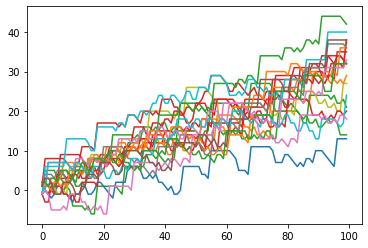

In [60]:
plot_cumul("cumul_tor", 20)

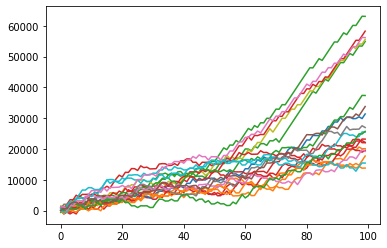

In [61]:
plot_cumul("cumul_tcp", 20)

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm

def vis_df_catorgy(label, features_df):
    features_df

    cat = []

    for i, x in enumerate(features_df):
        if labels[i] == label:
            cat.append(x)

    # Convert the list to a NumPy array
    cat_np = np.array(cat)

    # Repeat each row along the y-axis by a factor of 100
    cat_scaled = np.repeat(cat_np, repeats=10, axis=0)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(15, 10))

    # Set color boundaries and normalization
    cmap = plt.get_cmap('viridis')
    bounds = [-1, 0, 1, 2]
    norm = BoundaryNorm(bounds, cmap.N)

    # Display the scaled data
    im = ax.imshow(cat_scaled, cmap=cmap, interpolation='nearest', norm=norm)

    # Add a colorbar
    cbar = fig.colorbar(im, ax=ax, ticks=[-1, 0, 1])

    # Modify y-axis tick labels
    y_ticks = ax.get_yticks()
    y_tick_labels = [str(int(y_tick // 10)) for y_tick in y_ticks]
    ax.set_yticklabels(y_tick_labels)

    plt.show()



In [73]:
unique_elements, counts = np.unique(labels, return_counts=True)

# Zip the unique elements and their counts together
element_counts = zip(unique_elements, counts)

# Sort by counts in descending order and take the top 5
top_5_elements = sorted(element_counts, key=lambda x: x[1], reverse=True)[:5]

print(top_5_elements)

[('ebay.com', 288), ('adobe.com', 285), ('whatsapp.com', 285), ('hbomax.com', 282), ('amazon.com', 281)]


In [68]:
features_df_tcp[1]

array([ 1, -1,  1, ...,  0,  0,  0])

/var/folders/nw/xyhtrnxs1y10vv3fxl0sl24r0000gn/T/ipykernel_30442/3229973210.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_tick_labels)


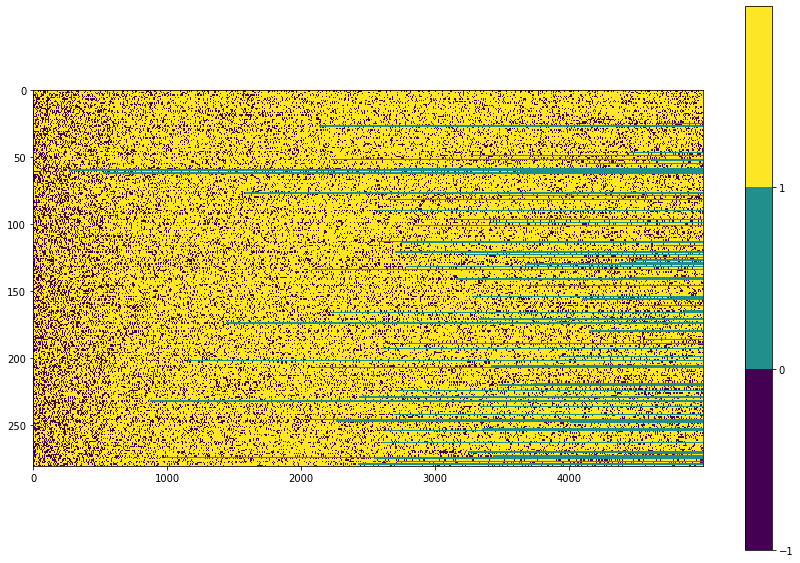

In [102]:
vis_df_catorgy("amazon.com", features_df_tcp)

/var/folders/nw/xyhtrnxs1y10vv3fxl0sl24r0000gn/T/ipykernel_30442/3669374126.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_tick_labels)


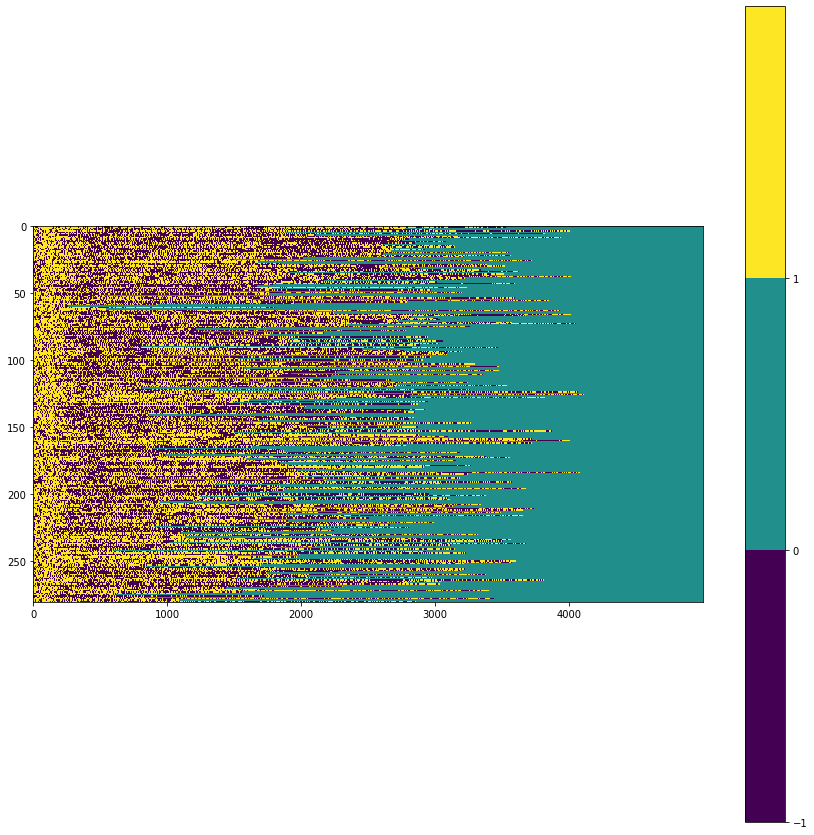

In [90]:
vis_df_catorgy("amazon.com", features_df_tor)

/var/folders/nw/xyhtrnxs1y10vv3fxl0sl24r0000gn/T/ipykernel_30442/3229973210.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_tick_labels)


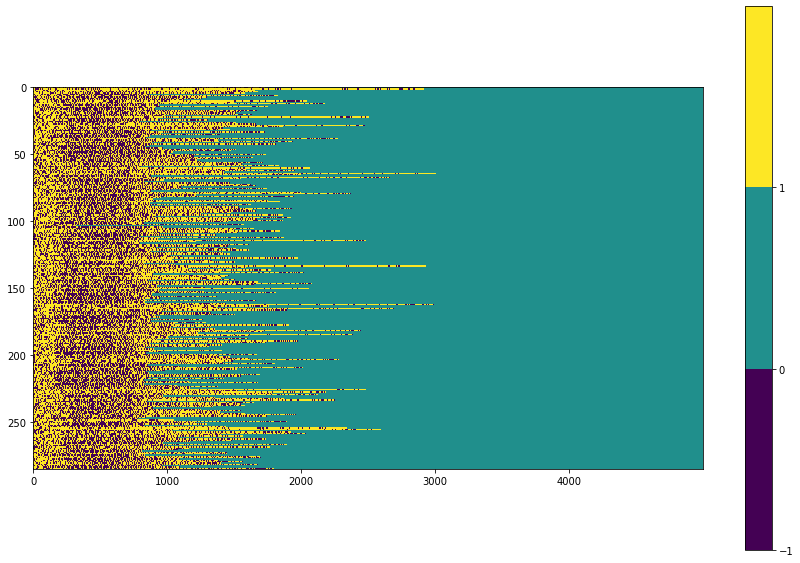

In [103]:
vis_df_catorgy("whatsapp.com", features_df_tor)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


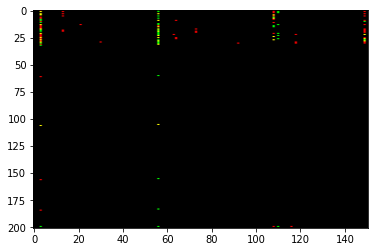

In [78]:
plt.imshow(np.pad(features_matrix[0], (0,1)), aspect="auto")